In [55]:
from __future__ import print_function ## Force python3-like printing

%matplotlib inline
from matplotlib import pyplot as plt

import os
import warnings

import numpy as np
from astropy.table import Table

import pycoco as pcc
import pycoco.kcorr as kcorr
from pycoco.colours import hex
reload(pcc) ## FOR DEV
reload(kcorr) ## FOR DEV
warnings.resetwarnings() ## FOR DEV

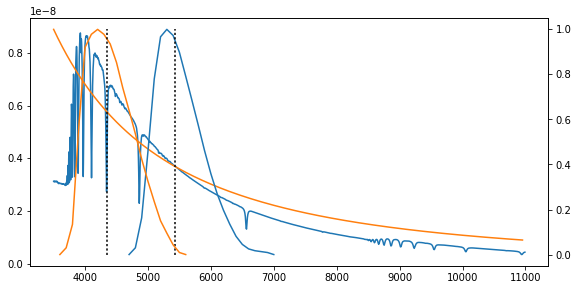

In [56]:
V = pcc.load_filter('/Users/berto/Code/CoCo/data/filters/BessellV.dat')
B = pcc.load_filter('/Users/berto/Code/CoCo/data/filters/BessellB.dat')

vega = kcorr.load_vega()
AB = kcorr.load_AB()

fig = plt.figure(figsize=[8, 4])
fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
                    right = 0.99, hspace=0, wspace = 0)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(vega.wavelength, vega.flux)
ax1.plot(AB.wavelength, AB.flux)

ax2.plot(V.wavelength, V.throughput)
ax2.plot([V.lambda_effective.value, V.lambda_effective.value], [0,1], color = hex["black"], ls = ":")
ax2.plot(B.wavelength, B.throughput)
ax2.plot([B.lambda_effective.value, B.lambda_effective.value], [0,1], color = hex["black"], ls = ":")

In [57]:
# print(kcorr.calc_offset_AB_minus_Vega("BessellV"))
# print(kcorr.calc_offset_AB_minus_Vega("BessellB"))
# print(kcorr.calc_AB_flux("BessellB"))
# print(kcorr.calc_vega_flux("BessellB"))
# kcorr.calc_vega_zp()
# # kcorr.calc_vega_mag("BessellV")
# kcorr.calc_vega_mag("BessellB")